<a href="https://colab.research.google.com/github/Matvezy/Body-Mesurments/blob/master/Copy_of_TrainExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/AI_2025_512px_ArmsLegsBodyProportionsFixed

/content/gdrive/MyDrive/AI_2025_512px_ArmsLegsBodyProportionsFixed


In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
class SizeEstimationDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('train.xml')
        root = tree.getroot()
        self.image_filenames = []
        self.asizes = []
        self.transform = transform
        for filename in root[1]:
            self.image_filenames.append([filename.attrib['front'], filename.attrib['side']])

            sizes = []
            for num in range(3):
                size = float(filename[num].attrib['size'])
                sizes.append([size])
            self.asizes.append(sizes)

        self.asizes = np.array(self.asizes).astype('float32')     

        assert len(self.image_filenames) == len(self.asizes)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        front = cv2.imread(self.image_filenames[index][0], 0)
        side = cv2.imread(self.image_filenames[index][1], 0)
        image= cv2.hconcat([front, side])
        sizes = self.asizes[index]
        image = Image.fromarray(image)
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, sizes

dataset = SizeEstimationDataset()

[['AITrainingLib/1/Front.png', 'AITrainingLib/1/Side.png'], ['AITrainingLib/2/Front.png', 'AITrainingLib/2/Side.png'], ['AITrainingLib/3/Front.png', 'AITrainingLib/3/Side.png'], ['AITrainingLib/4/Front.png', 'AITrainingLib/4/Side.png'], ['AITrainingLib/5/Front.png', 'AITrainingLib/5/Side.png'], ['AITrainingLib/6/Front.png', 'AITrainingLib/6/Side.png'], ['AITrainingLib/7/Front.png', 'AITrainingLib/7/Side.png'], ['AITrainingLib/8/Front.png', 'AITrainingLib/8/Side.png'], ['AITrainingLib/9/Front.png', 'AITrainingLib/9/Side.png'], ['AITrainingLib/10/Front.png', 'AITrainingLib/10/Side.png'], ['AITrainingLib/11/Front.png', 'AITrainingLib/11/Side.png'], ['AITrainingLib/12/Front.png', 'AITrainingLib/12/Side.png'], ['AITrainingLib/13/Front.png', 'AITrainingLib/13/Side.png'], ['AITrainingLib/14/Front.png', 'AITrainingLib/14/Side.png'], ['AITrainingLib/15/Front.png', 'AITrainingLib/15/Side.png'], ['AITrainingLib/16/Front.png', 'AITrainingLib/16/Side.png'], ['AITrainingLib/17/Front.png', 'AITrainin

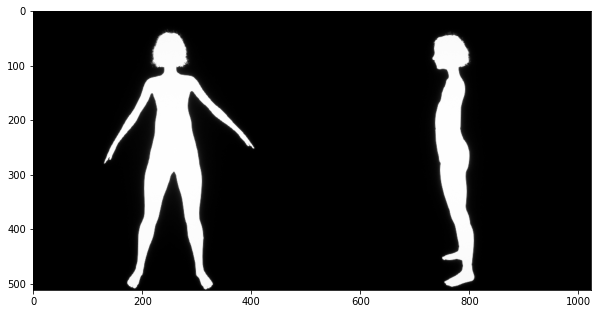

In [ ]:
print(dataset.image_filenames)
image, landmarks = dataset[2024] 
plt.figure(figsize=(10, 10))
plt.imshow(image.squeeze(), cmap='gray');
print(landmarks)

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=4)

The length of Train set is 1823
The length of Valid set is 202


In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([32, 1, 512, 1024])
torch.Size([32, 3, 1])


In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=3):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)

loss_min = np.inf
num_epochs = 500   
start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    #network.load_state_dict(torch.load('front_landmarks.pth')) 
    for step in range(1,len(train_loader)+1):
        for images, landmarks in train_loader:
          if torch.cuda.is_available():
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()  
        
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'bestsize_estimator_s.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 51/51  Loss: 22041.5306 
--------------------------------------------------
Epoch: 1  Train Loss: 774.7579  Valid Loss: 22041.5306
--------------------------------------------------

Minimum Validation Loss of 22041.5306 at epoch 1/500
Model Saved

Valid Steps: 51/51  Loss: 1348.5226 
--------------------------------------------------
Epoch: 2  Train Loss: 47.8662  Valid Loss: 1348.5226
--------------------------------------------------

Minimum Validation Loss of 1348.5226 at epoch 2/500
Model Saved

Valid Steps: 51/51  Loss: 9695.8157 
--------------------------------------------------
Epoch: 3  Train Loss: 43.3507  Valid Loss: 9695.8157
--------------------------------------------------
Valid Steps: 51/51  Loss: 9227.7581 
--------------------------------------------------
Epoch: 4  Train Loss: 40.2410  Valid Loss: 9227.7581
--------------------------------------------------
Valid Steps: 51/51  Loss: 1010.2393 
--------------------------------------------------
Epoch: 5

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-od19vfp4'


Valid Steps: 51/51  Loss: 500.7780 
--------------------------------------------------
Epoch: 17  Train Loss: 36.9409  Valid Loss: 500.7780
--------------------------------------------------
Valid Steps: 51/51  Loss: 303.7469 
--------------------------------------------------
Epoch: 18  Train Loss: 29.9828  Valid Loss: 303.7469
--------------------------------------------------
Valid Steps: 51/51  Loss: 19708.6858 
--------------------------------------------------
Epoch: 19  Train Loss: 26.6378  Valid Loss: 19708.6858
--------------------------------------------------
Valid Steps: 51/51  Loss: 14573.9585 
--------------------------------------------------
Epoch: 20  Train Loss: 26.5987  Valid Loss: 14573.9585
--------------------------------------------------
Valid Steps: 51/51  Loss: 288.5262 
--------------------------------------------------
Epoch: 21  Train Loss: 15.7465  Valid Loss: 288.5262
--------------------------------------------------
Valid Steps: 51/51  Loss: 329.9008 
-

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-mhphfwtx'


Valid Steps: 51/51  Loss: 1607.5611 
--------------------------------------------------
Epoch: 34  Train Loss: 8.9536  Valid Loss: 1607.5611
--------------------------------------------------
Valid Steps: 51/51  Loss: 316.7221 
--------------------------------------------------
Epoch: 35  Train Loss: 7.9866  Valid Loss: 316.7221
--------------------------------------------------
Valid Steps: 51/51  Loss: 109.1980 
--------------------------------------------------
Epoch: 36  Train Loss: 11.5902  Valid Loss: 109.1980
--------------------------------------------------
Valid Steps: 51/51  Loss: 2068.6822 
--------------------------------------------------
Epoch: 37  Train Loss: 10.7146  Valid Loss: 2068.6822
--------------------------------------------------
Valid Steps: 51/51  Loss: 557.5279 
--------------------------------------------------
Epoch: 38  Train Loss: 9.3107  Valid Loss: 557.5279
--------------------------------------------------
Valid Steps: 51/51  Loss: 545.8075 
--------

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('bestsize_estimator.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    landmarks = (landmarks )

    predictions = (best_network(images))
    
    print(predictions)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

tensor([[ 94.6795,  64.5601,  77.7816],
        [103.5186,  99.9964,  88.0642],
        [ 83.7111,  61.8324,  76.1026],
        [ 95.2529,  69.6353,  83.7331]], device='cuda:0')
Total number of test images: 202
Elapsed Time : 9.5838143825531


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


torch.Size([1, 512, 512])


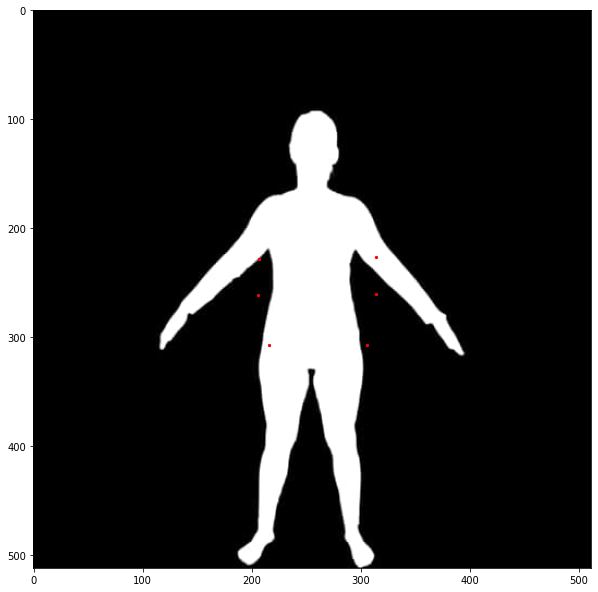

In [ ]:
from torch.autograd import Variable
imsize = 512
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
best_network = Network()
best_network.cuda()
best_network.load_state_dict(torch.load('bestsize_estimator.pth.pth')) 
best_network.eval()
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = cv2.imread(image_name, 0)
    image = Image.fromarray(image)
    image = TF.resize(image, (512,512))
    image = TF.to_tensor(image)
    #image = TF.normalize(image, [0.5], [0.5])  
    print(image.shape)
    image = Variable(image, requires_grad=True)
    return image.cuda()  #assumes that you're using GPU

image = image_loader("Front.jpg")

predictions = (best_network(image[None, ...]).cpu())
predictions = predictions.view(-1,6,2)
predictions = predictions.detach().numpy()
    
plt.figure(figsize=(10,40))
    
plt.imshow(image.cpu().detach().numpy().transpose(1,2,0).squeeze(), cmap='gray')
plt.scatter(predictions[0,:,0], predictions[0,:,1], c = 'r', s = 5)